# SQL Agent

This agent needs to:
* Fetch the necessar tables from the database
* Decide which tables are relevant to the user question
* Fetch the schemas for the relevant tables
* Generate a SQL query based on the question and the information from the schemas
* Check for common mistakes in the SQL query
* Execute the query and return results
* If the SQL query had errors, correct the query until it is successful
* Return a (textual) response based on the query results

---

In [1]:
from dotenv import load_dotenv
import pandas as pd
from pathlib import Path
import json
from dotenv import load_dotenv
import os 
from IPython.display import Image, display, Markdown
import pprint


Import the necessary classes from **Langchain** and **Langgraph**

In [2]:
from langchain.chat_models import init_chat_model
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage, HumanMessage

from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


In [3]:
# %pip install langgraph

In [4]:
# Load environment variables from .env file
load_dotenv()

True

## Load the required Database

In [5]:
import sqlite3

def generate_sqlite_database(sql_script, sqlite_db):

    # 1. Connect to the SQLite database
    conn = sqlite3.connect(sqlite_db)

    try:
        # 2. Read the SQL script from a file
        with open(sql_script, 'r') as f:
            sql_script = f.read()

        # 3. Execute the SQL script
        conn.executescript(sql_script)
        print("SQL script executed successfully.")

        # 4. Commit changes
        conn.commit()

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
        # Rollback changes in case of an error
        conn.rollback()

    finally:
        # 5. Close the connection
        conn.close()

# generate_sqlite_database('./data/chinook-sqlite.sql', './data/chinook.db')  

Source: https://github.com/lerocha/chinook-database/releases

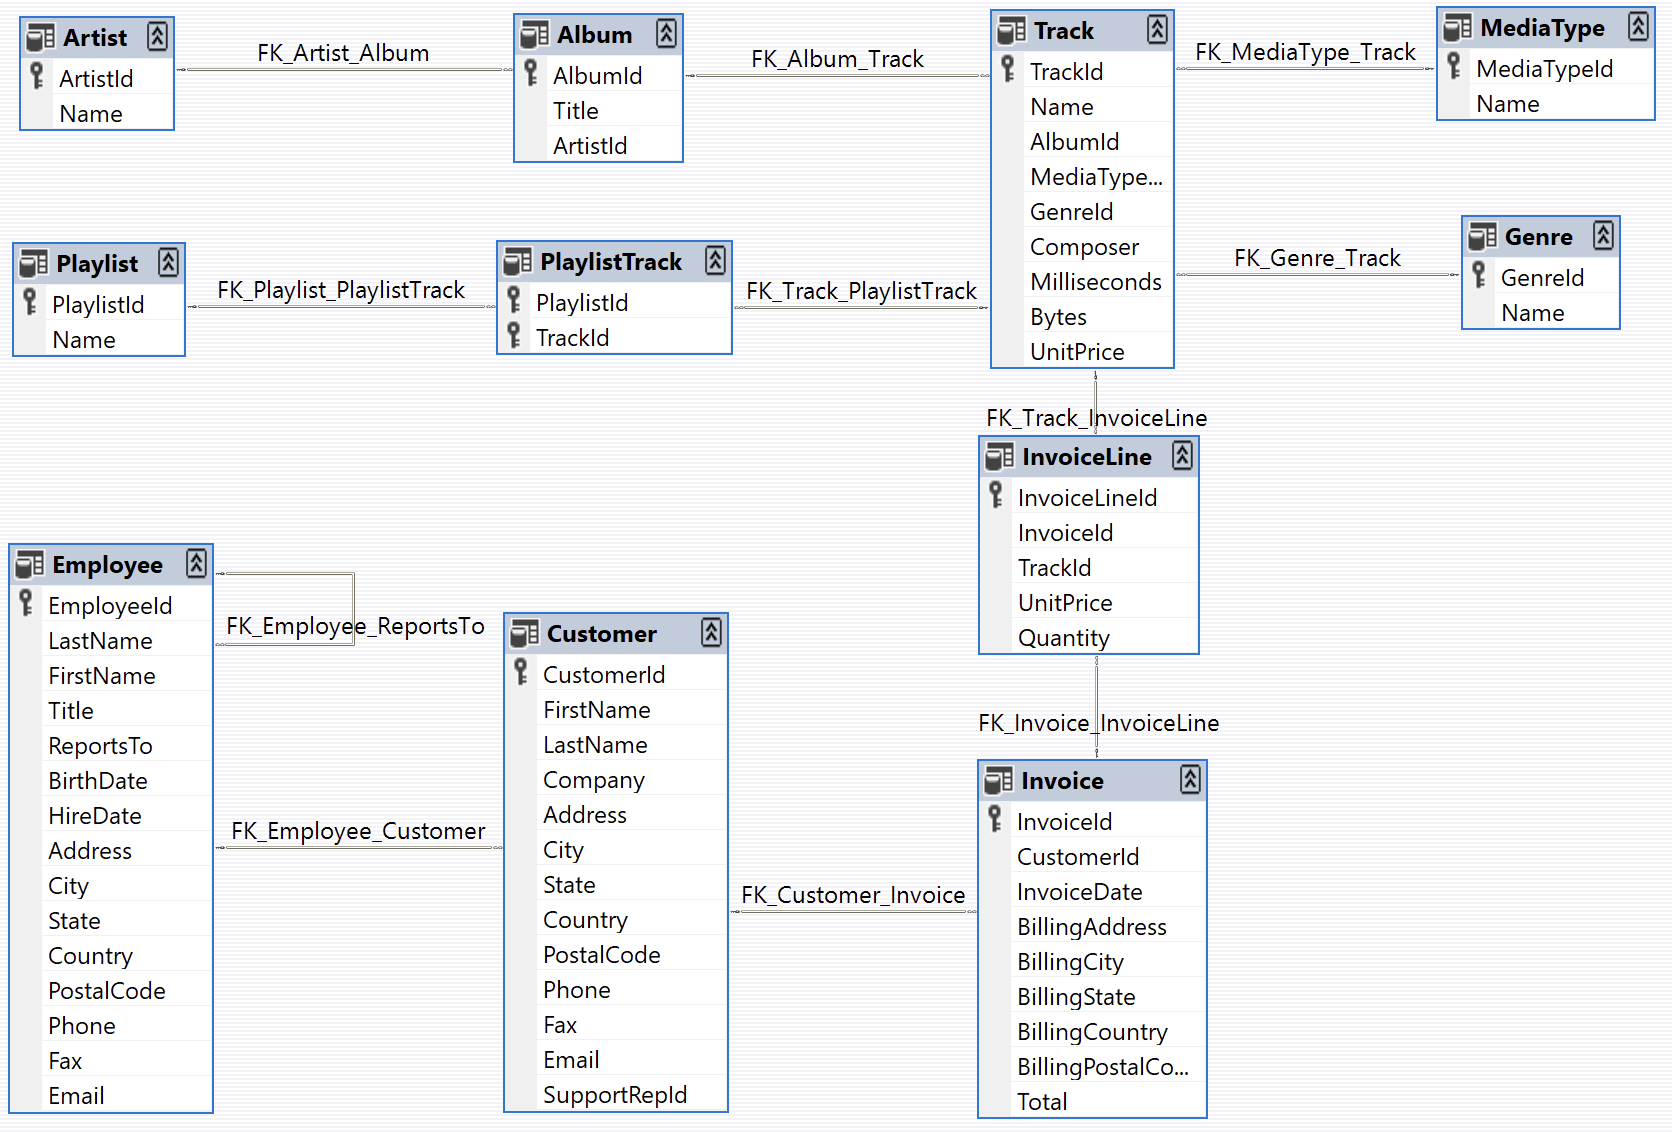

In [6]:
# This is a SQL wrapper provided by Langchain
chinook_db = SQLDatabase.from_uri("sqlite:///data/chinookdb.sqlite")

# Test the database
print(f"Dialect: {chinook_db.dialect}")
print(f"Available tables: {chinook_db.get_usable_table_names()}")
print(f'Sample output: {chinook_db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


In [7]:
# Select an LLM
# llm_model = "openai:"+os.getenv("OPENAI_MODEL")
llm_model = "openai:gpt-4o"
print(llm_model)
llm = init_chat_model(llm_model, temperature=0)

openai:gpt-4o


In [8]:
result = llm.invoke("What are the most popular songs by AC/DC?")
pprint.pprint(result.content)

('AC/DC has a number of iconic songs that have become classics in rock music. '
 'Some of their most popular tracks include:\n'
 '\n'
 '1. **"Back in Black"** - The title track from their 1980 album, it\'s one of '
 'their most recognizable songs.\n'
 '2. **"Highway to Hell"** - The title track from their 1979 album, it\'s a '
 'staple in rock music.\n'
 '3. **"Thunderstruck"** - Known for its electrifying guitar riff, this song '
 'from the 1990 album "The Razors Edge" is a fan favorite.\n'
 '4. **"You Shook Me All Night Long"** - A hit from the "Back in Black" album, '
 "it's one of their most enduring songs.\n"
 '5. **"T.N.T."** - From their 1975 album of the same name, it\'s a powerful '
 'anthem.\n'
 '6. **"Hells Bells"** - Another track from "Back in Black," known for its '
 'ominous bell tolling intro.\n'
 '7. **"Dirty Deeds Done Dirt Cheap"** - The title track from their 1976 '
 "album, it's a classic rock staple.\n"
 '8. **"Shoot to Thrill"** - Also from "Back in Black," it\'s

In [9]:
db = chinook_db

A *toolkit* is a set of tools in Langchain. In this case, we load built-in tools for listing tables, reading table schemas, and checking and running queries.

In [10]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



## Defining a ReAct Agent with SQL tools

In [11]:
SYSTEM_PROMPT = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

agent = create_react_agent(
    llm,
    tools,
    prompt=SYSTEM_PROMPT,
)

Test the agent with the provided tools

In [12]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_WEgBop03t4KMwoodVrRoqt9S)
 Call ID: call_WEgBop03t4KMwoodVrRoqt9S
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_5ES8YOKf9qfwHr8o0EWkOrWD)
 Call ID: call_5ES8YOKf9qfwHr8o0EWkOrWD
  Args:
    table_names: Genre, Track
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	N

In [13]:
inputs = [HumanMessage(content=question)]
result = agent.invoke({"messages": inputs})
display(Markdown(result['messages'][-1].content))

The genre with the longest average track length is "Sci Fi & Fantasy" with an average track length of approximately 2,911,783 milliseconds.

## Customizing the Agent as a Workflow

A potential issue of the ReAct agent is that it has access to all the tools, which might generate different rounds of inference until getting the correct result.

An alternative is to contraint the agent behavior with fewer tools and dedicated nodes in Langgraph. We will implement the following nodes:
* list database tables
* call the *get_schema()* tool
* generate a query
* check the query

In [14]:
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")

In [15]:
# 1. Create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}

# 2. Force the LLM to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

In [16]:
GENERATE_QUERY_SYSTEM_PROMPT = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)

# 3. Generate a SQL query
def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": GENERATE_QUERY_SYSTEM_PROMPT,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}

In [17]:
CHECK_QUERY_SYSTEM_PROMPT = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)

# 4. Check the generated query
def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": CHECK_QUERY_SYSTEM_PROMPT,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

## Assembling the Graph (workflow)

In [18]:
# It routes to the query checker every time a SQL query is generated, 
# or else will end if there are not tool calls
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"

We build the graph

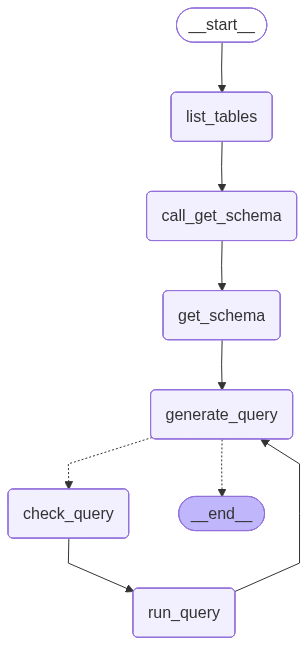

In [19]:
builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

workflow = builder.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))


In [20]:
for step in workflow.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_GqVkeVGJz4dZOY0RwLjxbvaO)
 Call ID: call_GqVkeVGJz4dZOY0RwLjxbvaO
  Args:
    table_names: Genre
  sql_db_schema (call_ZQUCCTmvsVjRckHxjZYtkPJ5)
 Call ID: call_ZQUCCTmvsVjRckHxjZYtkPJ5
  Args:
    table_names: Track
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Byte

In [21]:
# question = "Which are the top-3 genres having, on average, the longest tracks? Express the duration in minutes"
question = "What are the most popular songs by AC/DC?"

inputs = [HumanMessage(content=question)]
result = workflow.invoke({"messages": inputs})
display(Markdown(result['messages'][-1].content))

The most popular songs by AC/DC, based on the number of times they appear in invoices, are:

1. "Snowballed"
2. "Overdose"
3. "Inject The Venom"
4. "Spellbound"
5. "Put The Finger On You"

---

## Follow-up

Perform a similar exercise with a sample of a Netflix database:

Source: https://github.com/lerocha/netflixdb?tab=readme-ov-file

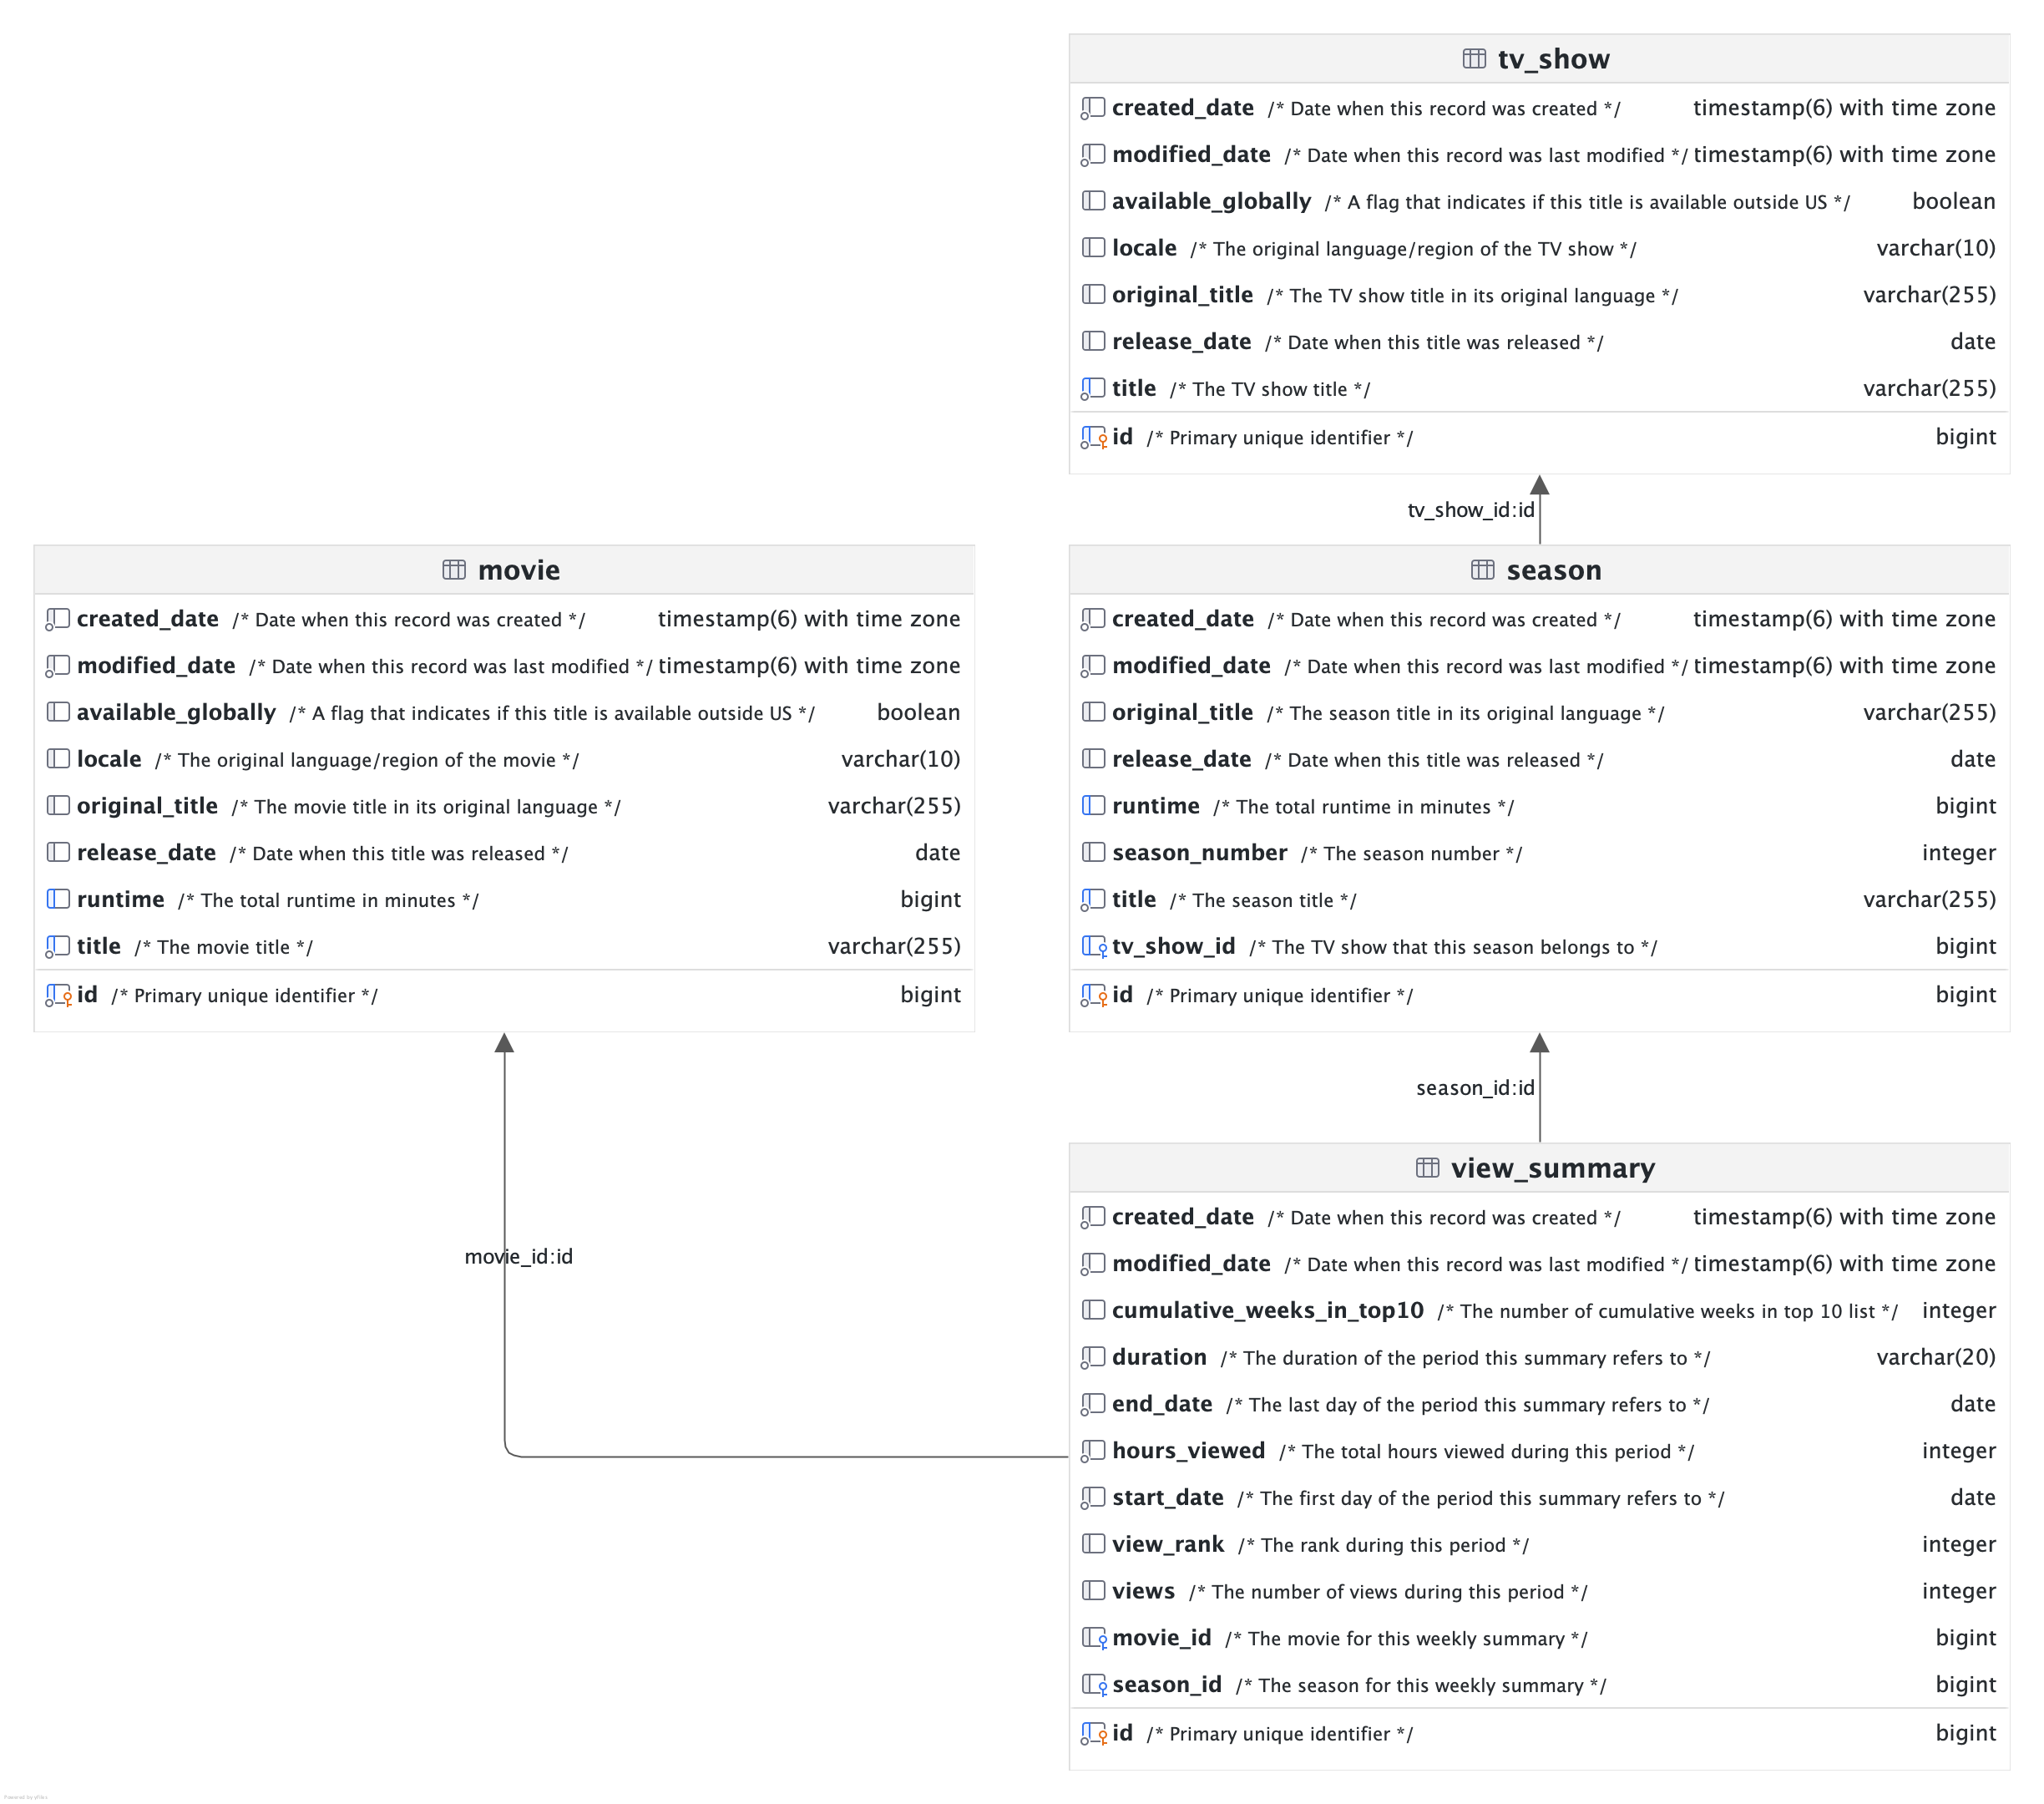

In [22]:
# conn = sqlite3.connect("./data/netflixdb.sqlite")
# cursor = conn.cursor()

# table_names = netflix_db.get_usable_table_names()
# for table in table_names:
#     if table.startswith("BATCH"):
#         cursor.execute("DROP TABLE IF EXISTS "+table)
#         conn.commit()
#         print(table, "removed")

# conn.close()

In [23]:
netflix_db = SQLDatabase.from_uri("sqlite:///data/netflixdb.sqlite")

print(f"Dialect: {netflix_db.dialect}")
print(f"Available tables: {netflix_db.get_usable_table_names()}")

# -- Top 10 movies (English)
question = "Which are the Top 10 movies (in English)?"

sql_query = """select v.view_rank, m.title, v.hours_viewed, m.runtime, v.views, v.cumulative_weeks_in_top10
from view_summary v
inner join movie m on m.id = v.movie_id
where duration = 'WEEKLY'
  and m.locale = 'en'
order by v.view_rank;"""

print(f'Sample output: {netflix_db.run(sql_query)}')

Dialect: sqlite
Available tables: ['episode', 'movie', 'season', 'tv_show', 'view_summary']
Sample output: [(1, 'Mother of the Bride', 38100000, 90, 25400000, 2), (1, 'Mother of the Bride', 40000000, 90, 26700000, 1), (1, 'Atlas', 63100000, 120, 31600000, 2), (1, 'Atlas', 56300000, 120, 28200000, 1), (1, 'Irish Wish', 40000000, 94, 25500000, 2), (1, 'Despicable Me 3', 23900000, 90, 15900000, 1), (1, 'Rebel Moon — Part Two: The Scargiver', 38800000, 124, 18800000, 2), (1, 'Rebel Moon — Part Two: The Scargiver', 44200000, 124, 21400000, 1), (1, 'Rebel Moon — Part One: A Child of Fire', 77000000, 136, 34000000, 2), (1, 'Rebel Moon — Part One: A Child of Fire', 54100000, 136, 23900000, 1), (1, 'The Equalizer 3', 26800000, 109, 14800000, 1), (1, 'Mea Culpa', 32000000, 120, 16000000, 1), (1, 'What Jennifer Did', 26100000, 87, 18000000, 1), (1, 'Code 8 Part II', 33400000, 100, 20000000, 1), (1, 'Leave the World Behind', 106200000, 142, 44900000, 2), (1, 'Leave the World Behind', 98700000, 142